In [75]:
!pip install xgboost

# setting logging to print only error messages from Sklearnex
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from datetime import datetime

from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error,mean_absolute_error
import math
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

sns.set_theme(palette="Set2")
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')


def get_mda(y, yhat):
    """Mean Directional Accuracy, as per:
    https://www.wikiwand.com/en/Mean_Directional_Accuracy
    """
    a = np.sign(np.diff(y))
    b = np.sign(np.diff(yhat))
    return np.sum(a == b)/a.shape[0]

In [76]:
df=pd.read_csv("APPLE BP DATA.csv")

In [77]:
df.head()

,Date,Open,High,Low,Close,Volume,NASDAQ,Change
0,01-04-2014,19.205713,19.352501,19.170357,19.344643,200760000,3658.399902,NaN
1,02-04-2014,19.370714,19.410000,19.295000,19.376785,180420800,3665.989990,0.032142
2,03-04-2014,19.335358,19.375000,19.201429,19.242500,162344000,3637.580078,-0.134285
3,04-04-2014,19.278929,19.285713,18.949286,18.993570,275251200,3539.379883,-0.248930
4,07-04-2014,18.857857,18.960714,18.638929,18.695356,289850400,3507.750000,-0.298214


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2205 non-null   object 
 1   Open    2205 non-null   float64
 2   High    2205 non-null   float64
 3   Low     2205 non-null   float64
 4   Close   2205 non-null   float64
 5   Volume  2205 non-null   int64  
 6   NASDAQ  2205 non-null   float64
 7   Change  2204 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 137.9+ KB


## Convert the "time" column to the datetime type

In [79]:
df["Date"] = pd.to_datetime(df["Date"])

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2205 non-null   datetime64[ns]
 1   Open    2205 non-null   float64       
 2   High    2205 non-null   float64       
 3   Low     2205 non-null   float64       
 4   Close   2205 non-null   float64       
 5   Volume  2205 non-null   int64         
 6   NASDAQ  2205 non-null   float64       
 7   Change  2204 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 137.9 KB


In [81]:
df.set_index('Date',inplace=True)

In [82]:
df.head()

,Open,High,Low,Close,Volume,NASDAQ,Change
Date,,,,,,,
2014-01-04,19.205713,19.352501,19.170357,19.344643,200760000,3658.399902,NaN
2014-02-04,19.370714,19.410000,19.295000,19.376785,180420800,3665.989990,0.032142
2014-03-04,19.335358,19.375000,19.201429,19.242500,162344000,3637.580078,-0.134285
2014-04-04,19.278929,19.285713,18.949286,18.993570,275251200,3539.379883,-0.248930
2014-07-04,18.857857,18.960714,18.638929,18.695356,289850400,3507.750000,-0.298214


In [83]:
df.tail()

,Open,High,Low,Close,Volume,NASDAQ,Change
Date,,,,,,,
2022-12-23,130.919998,132.419998,129.639999,131.860001,63814900,10985.45020,-0.369995
2022-12-27,131.380005,131.410004,128.720001,130.029999,69007800,10822.50977,-1.830002
2022-12-28,129.669998,131.029999,125.870003,126.040001,85438400,10679.33984,-3.989998
2022-12-29,127.989998,130.479996,127.730003,129.610001,75703700,10951.04981,3.570000
2022-12-30,128.410004,129.949997,127.430000,129.929993,77034200,10939.75977,0.319992


# Missing entries


In [84]:
min(df.index)

Timestamp('2014-01-04 00:00:00')

In [85]:
max(df.index)

Timestamp('2022-12-30 00:00:00')

In [86]:
all_datetimes = pd.date_range(min(df.index), max(df.index), freq="D")
all_datetimes

DatetimeIndex(['2014-01-04', '2014-01-05', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-11',
               '2014-01-12', '2014-01-13',
               ...
               '2022-12-21', '2022-12-22', '2022-12-23', '2022-12-24',
               '2022-12-25', '2022-12-26', '2022-12-27', '2022-12-28',
               '2022-12-29', '2022-12-30'],
              dtype='datetime64[ns]', length=3283, freq='D')

In [46]:
all_datetimes.shape

(3283,)

# Supplying missing values


## Insert missing datetimes

In [47]:
all_datetimes_df = pd.DataFrame(index=all_datetimes)
all_datetimes_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3283 entries, 2014-01-04 to 2022-12-30
Freq: D
Empty DataFrame

In [48]:
df = pd.merge(all_datetimes_df, df, how="left", left_index=True, right_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3283 entries, 2014-01-04 to 2022-12-30
Freq: D
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2205 non-null   float64
 1   High    2205 non-null   float64
 2   Low     2205 non-null   float64
 3   Close   2205 non-null   float64
 4   Volume  2205 non-null   float64
 5   NASDAQ  2205 non-null   float64
 6   Change  2204 non-null   float64
dtypes: float64(7)
memory usage: 334.2 KB


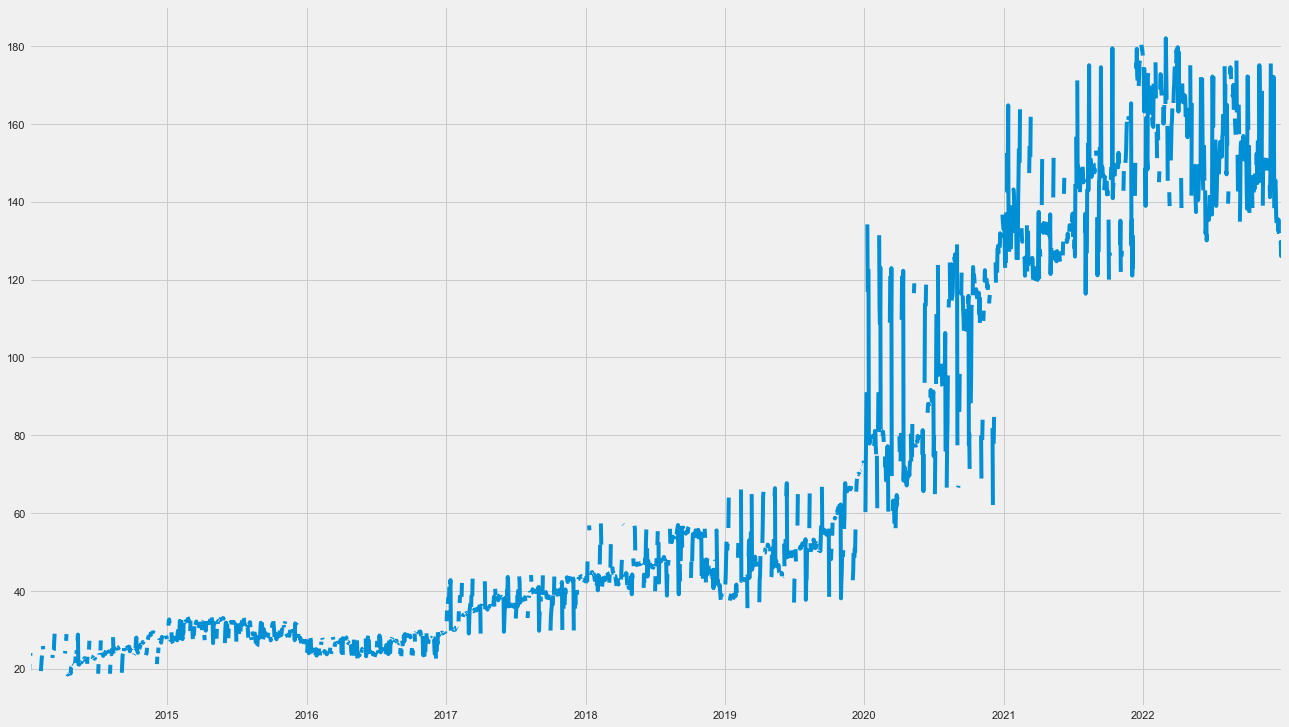

In [49]:
plot = df['Close'].plot(figsize=(20, 12))

# forward fill

In [50]:
df["ffilled"] = df["Close"].ffill()
df["NASDAQ"]=df["NASDAQ"].ffill()
df.head(12)

,Open,High,Low,Close,Volume,NASDAQ,Change,ffilled
2014-01-04,19.205713,19.352501,19.170357,19.344643,200760000.0,3658.399902,NaN,19.344643
2014-01-05,21.142857,21.242857,20.941429,21.124287,244048000.0,3594.360107,0.049645,21.124287
2014-01-06,NaN,NaN,NaN,NaN,NaN,3594.360107,NaN,21.124287
2014-01-07,23.379999,23.517500,23.282499,23.379999,152892000.0,3894.330078,0.147499,23.379999
2014-01-08,23.725000,24.155001,23.702499,24.032499,194044000.0,3879.669922,0.132499,24.032499
2014-01-09,NaN,NaN,NaN,NaN,NaN,3879.669922,NaN,24.032499
2014-01-10,25.147499,25.172501,24.674999,24.795000,205965200.0,3984.739990,-0.392500,24.795000
2014-01-11,NaN,NaN,NaN,NaN,NaN,3984.739990,NaN,24.795000
2014-01-12,29.702499,29.812500,27.817499,28.767500,335256000.0,4287.810059,-0.965000,28.767500
2014-01-13,NaN,NaN,NaN,NaN,NaN,4287.810059,NaN,28.767500


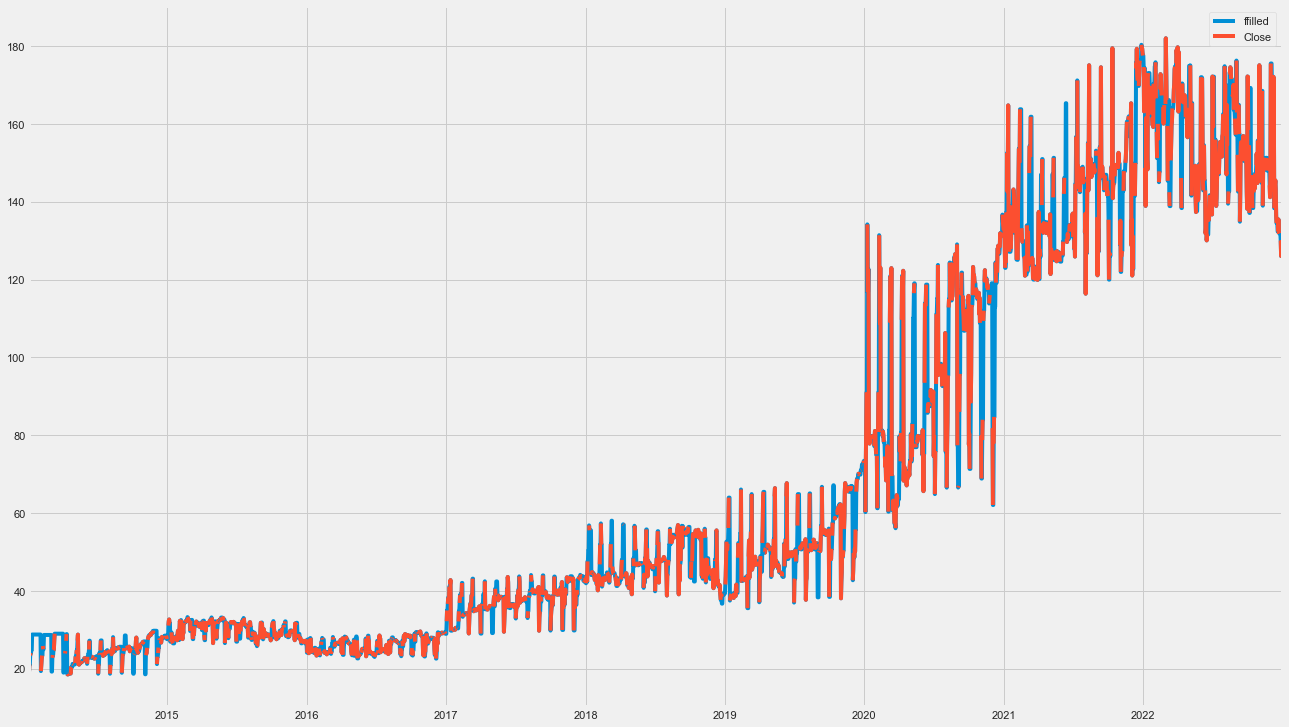

In [51]:
df = df[["ffilled", "Close","NASDAQ","Change"]]
plot = df[["ffilled", "Close"]].plot(figsize=(20, 12))

In [52]:
df.ffilled

2014-01-04     19.344643
2014-01-05     21.124287
2014-01-06     21.124287
2014-01-07     23.379999
2014-01-08     24.032499
                 ...    
2022-12-26    131.860001
2022-12-27    130.029999
2022-12-28    126.040001
2022-12-29    129.610001
2022-12-30    129.929993
Freq: D, Name: ffilled, Length: 3283, dtype: float64

In [53]:
df.rename(columns={"ffilled": "close"}, inplace=True)
df

,close,Close,NASDAQ,Change
2014-01-04,19.344643,19.344643,3658.399902,NaN
2014-01-05,21.124287,21.124287,3594.360107,0.049645
2014-01-06,21.124287,NaN,3594.360107,NaN
2014-01-07,23.379999,23.379999,3894.330078,0.147499
2014-01-08,24.032499,24.032499,3879.669922,0.132499
...,...,...,...,...
2022-12-26,131.860001,NaN,10985.450200,NaN
2022-12-27,130.029999,130.029999,10822.509770,-1.830002
2022-12-28,126.040001,126.040001,10679.339840,-3.989998
2022-12-29,129.610001,129.610001,10951.049810,3.570000


In [54]:
df.drop(["Close"],axis=1,inplace=True)

In [55]:
df

,close,NASDAQ,Change
2014-01-04,19.344643,3658.399902,NaN
2014-01-05,21.124287,3594.360107,0.049645
2014-01-06,21.124287,3594.360107,NaN
2014-01-07,23.379999,3894.330078,0.147499
2014-01-08,24.032499,3879.669922,0.132499
...,...,...,...
2022-12-26,131.860001,10985.450200,NaN
2022-12-27,130.029999,10822.509770,-1.830002
2022-12-28,126.040001,10679.339840,-3.989998
2022-12-29,129.610001,10951.049810,3.570000


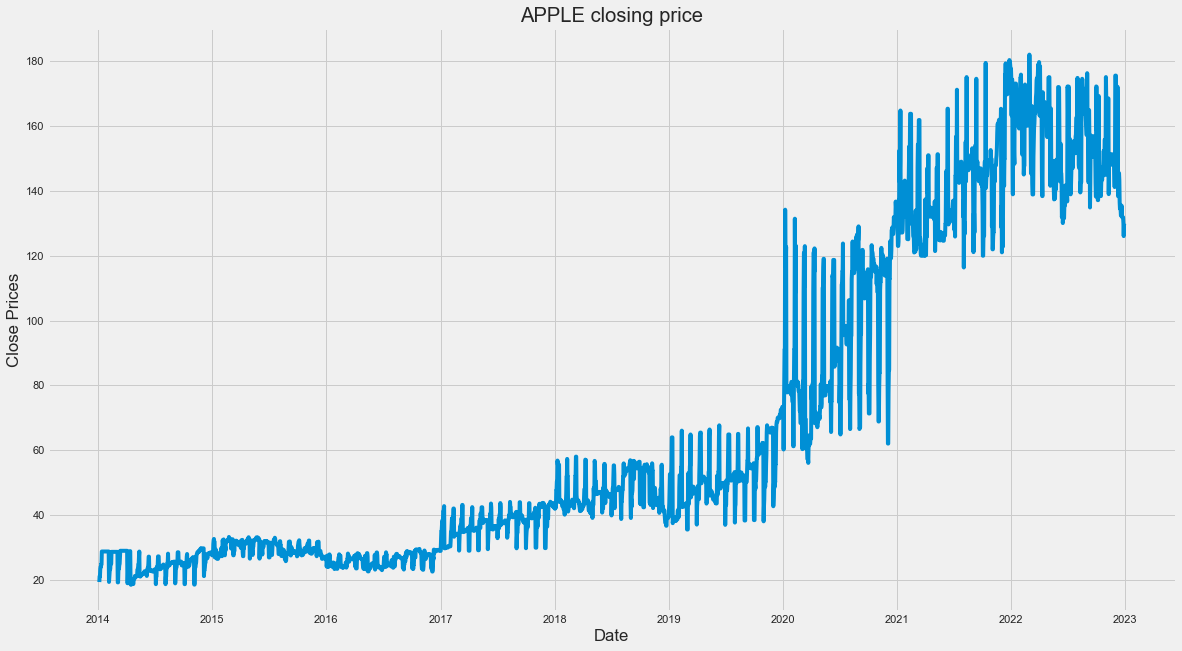

In [56]:
#plot close price
plt.figure(figsize=(18,10))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['close'])
plt.title('APPLE closing price')
plt.show()

# checking stationarity of the data


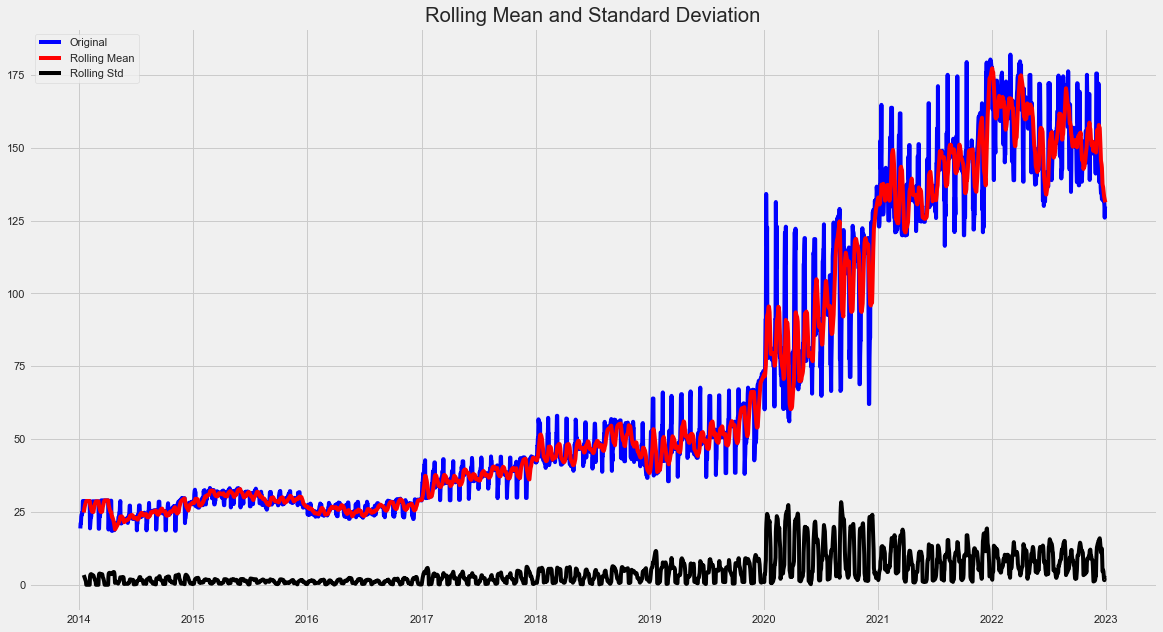

Results of dickey fuller test
Test Statistics                   0.752875
p-value                           0.990836
No. of lags used                 29.000000
Number of observations used    3253.000000
critical value (1%)              -3.432362
critical value (5%)              -2.862429
critical value (10%)             -2.567243
dtype: float64


In [57]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    plt.figure(figsize=(18, 10))

    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df.close)

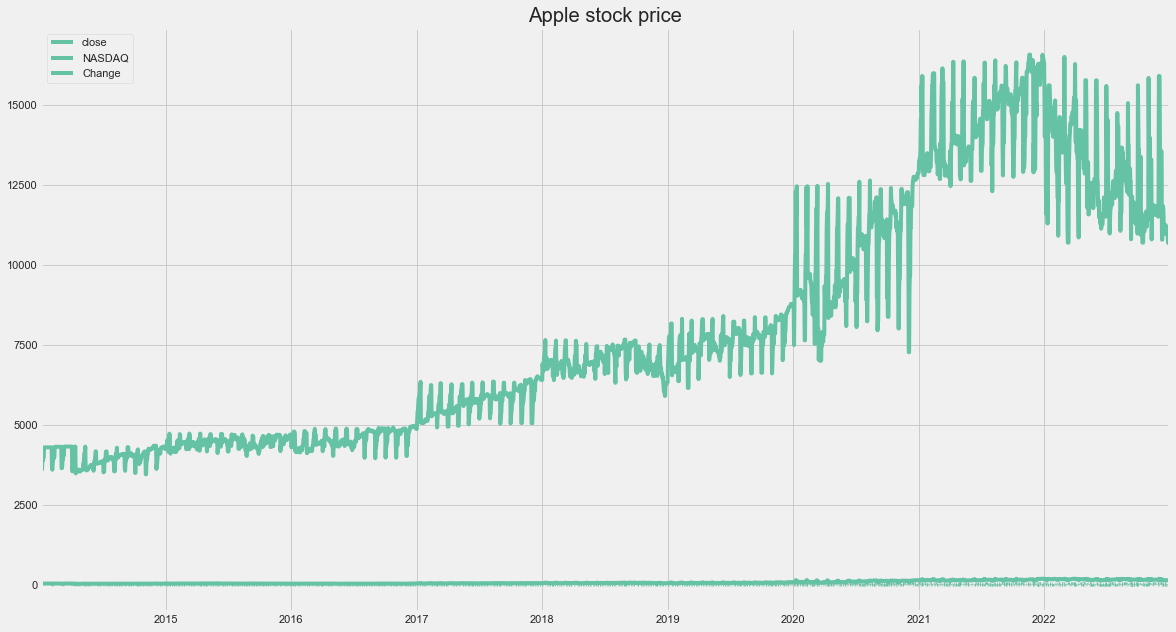

In [58]:
df.plot(style='-',
        figsize=(18, 10),
        color=color_pal[0],
        title='Apple stock price')
plt.show()

## Train / Test Split¶


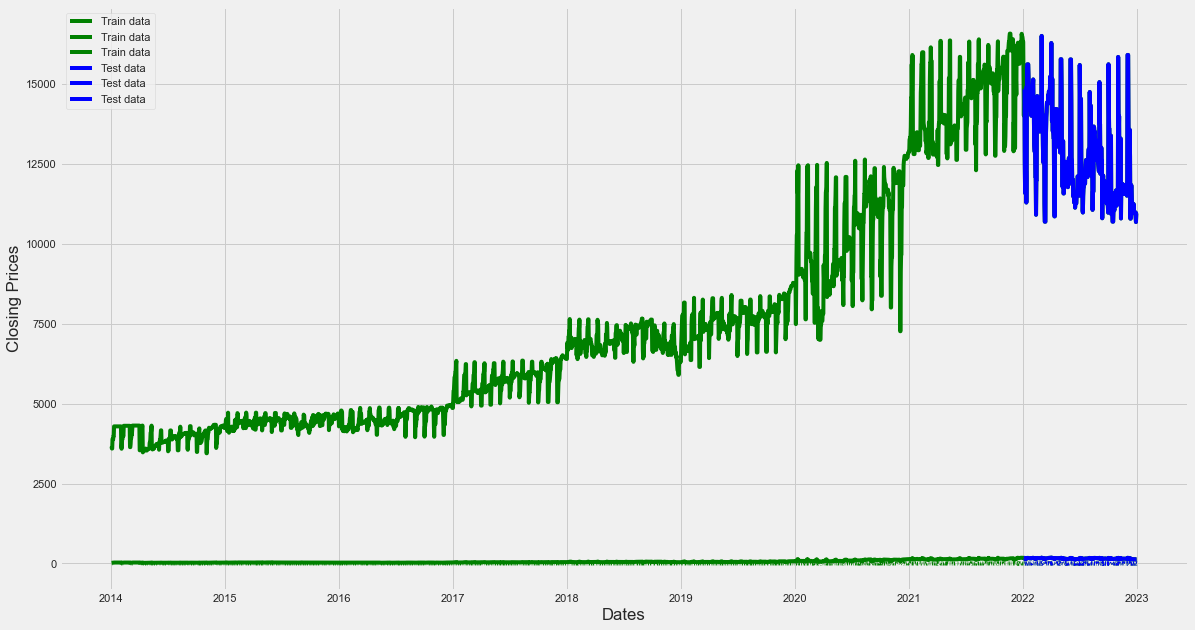

In [59]:
train_data = df.loc[df.index < '01-04-2022']
test_data = df.loc[df.index >= '01-04-2022']
plt.figure(figsize=(18,10))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [60]:
train_data.shape

(2922, 3)

In [61]:
test_data.tail()

,close,NASDAQ,Change
2022-12-26,131.860001,10985.45020,NaN
2022-12-27,130.029999,10822.50977,-1.830002
2022-12-28,126.040001,10679.33984,-3.989998
2022-12-29,129.610001,10951.04981,3.570000
2022-12-30,129.929993,10939.75977,0.319992


In [62]:
test_data.shape

(361, 3)

In [63]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# Visualize our Feature / Target Relationship¶


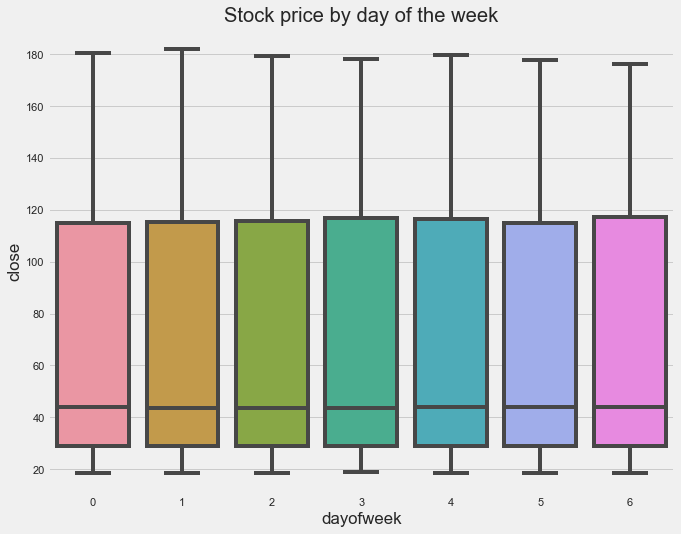

In [64]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='dayofweek', y='close')
ax.set_title('Stock price by day of the week')
plt.show()

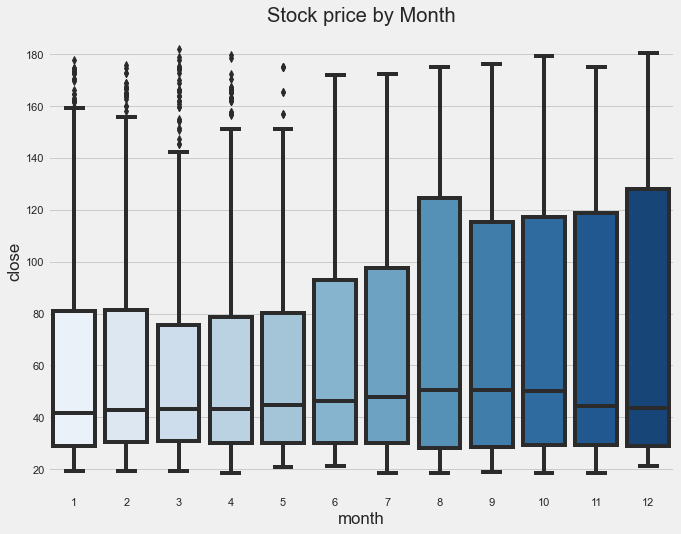

In [65]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='close', palette='Blues')
ax.set_title('Stock price by Month')
plt.show()

# Create our Model¶


In [66]:
train = create_features(train_data)
test = create_features(test_data)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year','NASDAQ','Change']
TARGET = 'close'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [67]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:68.26962	validation_1-rmse:153.72260
[100]	validation_0-rmse:25.42115	validation_1-rmse:75.26148
[200]	validation_0-rmse:9.81740	validation_1-rmse:46.73115
[300]	validation_0-rmse:4.43514	validation_1-rmse:34.51810
[400]	validation_0-rmse:2.82020	validation_1-rmse:24.76233
[500]	validation_0-rmse:2.35150	validation_1-rmse:22.09482
[600]	validation_0-rmse:2.19404	validation_1-rmse:19.57765
[700]	validation_0-rmse:2.11020	validation_1-rmse:17.81767
[800]	validation_0-rmse:2.05490	validation_1-rmse:16.72620
[900]	validation_0-rmse:2.00362	validation_1-rmse:16.25856
[999]	validation_0-rmse:1.96171	validation_1-rmse:15.94507


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

# Feature Importance¶


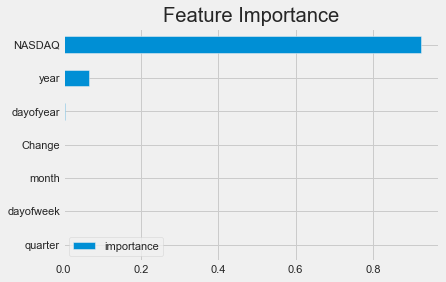

In [68]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test


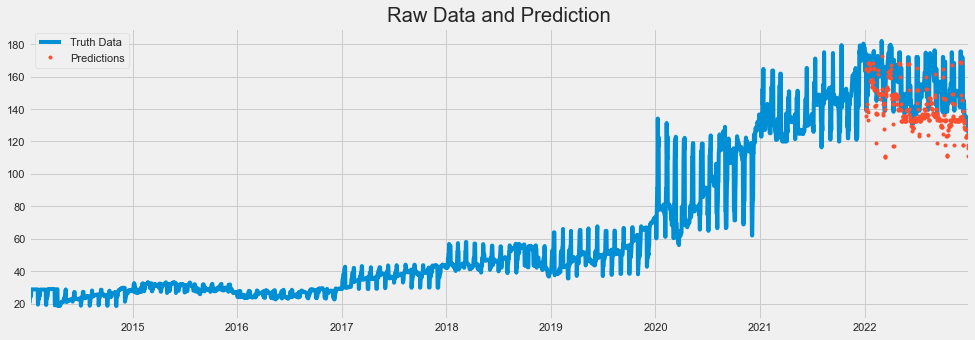

In [69]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['close']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [70]:
df['prediction'].tail(365)

2021-12-31           NaN
2022-01-01           NaN
2022-01-02           NaN
2022-01-03           NaN
2022-01-04    164.510620
                 ...    
2022-12-26    123.849564
2022-12-27    118.090996
2022-12-28    111.327438
2022-12-29    115.887688
2022-12-30    117.668175
Freq: D, Name: prediction, Length: 365, dtype: float32

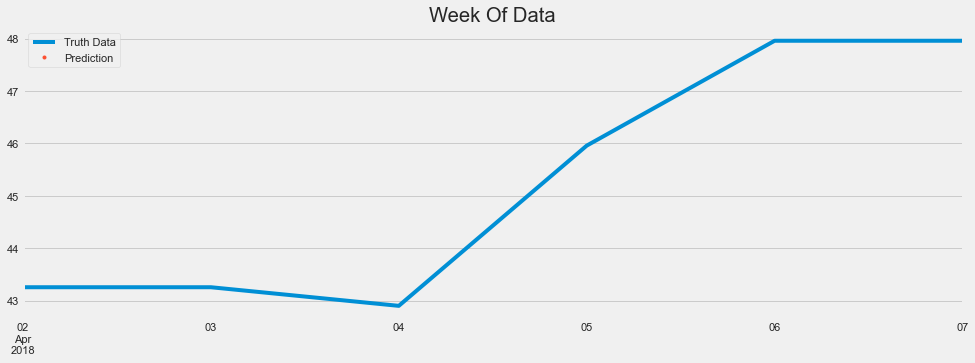

In [71]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['close'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# Score (RMSE)

In [72]:
score = np.sqrt(mean_squared_error(test['close'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 15.95


# Calculate error

In [73]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2022-03-12    28.562058
2022-03-13    28.562058
2022-08-21    28.024414
2022-08-20    28.024414
2022-08-17    28.023498
2022-03-11    27.927673
2022-08-18    27.765122
2022-08-19    27.695480
2022-08-24    27.289978
2022-10-15    27.172310
Name: error, dtype: float64

In [74]:
# report performance
mse = mean_squared_error(test['prediction'], test[TARGET])
print('MSE: '+str(mse))
mae = mean_absolute_error(test['prediction'], test[TARGET])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test['prediction'], test[TARGET]))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(test[TARGET] - test['prediction'])/np.abs(test['prediction']))
print('MAPE: '+str(mape))

MSE: 254.24531651449837
MAE: 14.61822981502662
RMSE: 15.945071856674035
MAPE: 0.10592001318676111
